In [3]:
import nipype
import os,glob,sys,shutil
sys.path.append("/usr/lib/ants/")
import nipype.interfaces.fsl as fsl
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nipype.interfaces.io as nio
import nipype.interfaces.ants.legacy as antsL
import nipype.interfaces.ants as ants
from nipype.interfaces.ants import Registration
from nipype.interfaces.ants import RegistrationSynQuick
from IPython.display import Image
from nipype.interfaces.fsl import Info
from nipype.interfaces.ants import WarpImageMultiTransform

from os.path import join as opj
#from nipype.caching import Memory
MNI_template = Info.standard_image('MNI152_T1_1mm_brain.nii.gz')

#mem = Memory(base_dir='/data/HCP_Data/NipypeScratch/')
regScratchDir = "/data/HCP_Data/NipypeScratch/hcp_pbx_to_MNI/"

In [6]:
# """
# Setup for DataGrabber inputs needed for probtrackx2
# """
datasource = pe.Node(interface=nio.DataGrabber(infields=['subject_id'],
        outfields=['nodif_brain_mask','xfm','invxfm','thsamples','phsamples','fsamples','mniROIs','pbxResults']),
        name='datasource')
# create a node to obtain the functional images
datasource.inputs.base_directory = "/data/HCP_BedpostData/"
datasource.inputs.template ='*'
datasource.inputs.sort_filelist = True
datasource.inputs.field_template = dict(
    thsamples='%s/T1w/Diffusion.bedpostX/merged_%s.nii*',
    fsamples='%s/T1w/Diffusion.bedpostX/merged_%s.nii*',
    phsamples='%s/T1w/Diffusion.bedpostX/merged_%s.nii*',
    nodif_brain_mask='%s/T1w/Diffusion.bedpostX/%s.nii*', 
    xfm='%s/MNINonLinear/xfms/%s.nii*',
    invxfm='%s/MNINonLinear/xfms/%s.nii*',
    mniROIs='addlInfo/subjContainer/%s/DTI_ROIs/Human_*_wimt.nii.gz',
    pbxResults='addlInfo/subjContainer/%s/pbxResults/DTI/Human_*_fdt_paths.nii.gz'
    )


# addlInfo/subjContainer/129634/pbxResults/DTI$ ls

datasource.inputs.template_args = dict(
             thsamples = [['subject_id','th1samples']],
             phsamples =  [['subject_id','ph1samples']],
             fsamples =  [['subject_id','f1samples']],
             nodif_brain_mask = [['subject_id','nodif_brain_mask']],
             xfm = [['subject_id','acpc_dc2standard']],
             invxfm = [['subject_id', 'standard2acpc_dc']],
            mniROIs=[['subject_id']],
        pbxResults=[['subject_id']]
        )

In [9]:
subjRootDir = "/data/HCP_BedpostData/"
FULL_SUBJECT_LIST = [x for x in os.listdir(subjRootDir) if os.path.isdir( subjRootDir+'/addlInfo/subjContainer/'+x+'/pbxResults/DTI')]
print(len(FULL_SUBJECT_LIST),"Subjects are potentially available to be processed!")

686 Subjects are potentially available to be processed!


In [5]:
"""
Setup for Registration  Pipeline InfoSource i.e. subjects
"""
subj_infosource = pe.Node(interface=util.IdentityInterface(fields=['subject_id']),  name="subj_infosource")
#infosource.iterables = ('subject_id', SampleSubjList)
subj_infosource.iterables = ('subject_id', FULL_SUBJECT_LIST)
### Above just converts the list of subjects into an iterable list I can connect to the next part of the pipeline

In [6]:
warp_PBX_to_MNI = pe.Node(WarpImageMultiTransform())


# #roi = "/data/HCP_Data/EHECHT_ROIS/Human_Hypothalamus_Left.nii.gz"
# roiList = glob.glob("/data/HCP_Data/EHECHT_ROIS/Human_*nii.gz")

# #### RIGID BODY REGISTRATION OF DTI -- >  Struct Brain    using RegSynQuick
# reg_DTI_to_Struct = pe.Node( RegistrationSynQuick(
#                              num_threads=3,
#                              transform_type='r'),
#                              name='reg_DTI_to_Struct')

# reg_Struct_to_MNI = pe.Node( RegistrationSynQuick(
#                              num_threads=6, fixed_image=MNI_template),
#                              name='reg_Struct_to_MNI')

# warp_ROIs_MNI_to_DTI = pe.Node( WarpImageMultiTransform(invert_affine = [1],
#                                     use_nearest=True,
#                                     ), iterfield=['input_image'], name="warp_ROIs_MNI_to_DTI")

# warp_ROIs_MNI_to_DTI.iterables = ('input_image', roiList)


# ## CREATE A DATASINK TO COPY OVER THE ROIS IN STANDARD SPACE-- ALSO COPY OVER THE XFMS IN FUTURE VERSION

# datasink = pe.Node(nio.DataSink(), name='datasink')
# datasink.inputs.base_directory = '/data/HCP_Data/NipypeScratch/datastinker/'
# #workflow.connect(inputnode, 'subject_id', datasink, 'container')

# #roi_datasink = pe.Node(nio.DataSink(parameterization=False), name='roi_datasink')
# #roi_datasink.inputs.base_directory = '/data/HCP_Data/NipypeScratch/datastinker/'



# datasink.inputs.substitutions = [ ('_subject_id_', ''), ('_input_image_..data..HCP_Data..EHECHT_ROIS..', 'DTI_ROIs/'),
                                  
#                                  ('Human_BasalForebrain_Bilat.nii.gz/',''),
#                                  ('Human_BasalForebrain_Left.nii.gz/',''),
#                                  ('Human_BasalForebrain_Right.nii.gz/',''),
#                                  ('Human_Hypothalamus_Right.nii.gz/',''),
#                                  ('Human_Hypothalamus_Left.nii.gz/',''),
#                                  ('Human_Hypothalamus_Bilat.nii.gz/','')
#                                 ]
# #roi_datasink.inputs.substitutions = datasink.inputs.substitutions

# # substitutions=[]
# # for i in range(len(FULL_SUBJECT_LIST[:2])):
# #     substitutions+= [("_neck_remove"+str(i), subject_list[i])]
# #     substitutions+= [("subject_id_", "")]
# # sink.inputs.substitutions =substitutions 

# #https://gist.github.com/Crisly/10395192
# # Concatenate DTI_to_Struct and Struct_to_MNI into a list
# merge_xfms = pe.Node(util.Merge(2), iterfield=['in2'], name='merge_xfms')

In [7]:
run_hcp_reg  = pe.Workflow(name="run_hcp_reg_pipeline")
run_hcp_reg.base_dir = regScratchDir

### Conneccts list ofls -al subjects to the data source generator
run_hcp_reg.connect(subj_infosource,'subject_id',datasource,'subject_id')

## Connect inputs for registering the DTI to Structural Image (Rigid Registration)
run_hcp_reg.connect( datasource,'struct_brain',reg_DTI_to_Struct,'fixed_image')
run_hcp_reg.connect( datasource,'nodif_brain',reg_DTI_to_Struct,'moving_image')

## Connect the inputs for registering Structural to MNI 1mm template-- template is specified in fxn
run_hcp_reg.connect( datasource,'struct_brain',reg_Struct_to_MNI,'moving_image')

run_hcp_reg.connect( reg_Struct_to_MNI, "inverse_warp_field", merge_xfms, "in2"    )
run_hcp_reg.connect( reg_DTI_to_Struct, "out_matrix",merge_xfms, "in1"   )
run_hcp_reg.connect( merge_xfms,  'out', warp_ROIs_MNI_to_DTI, 'transformation_series')
run_hcp_reg.connect( datasource, 'nodif_brain', warp_ROIs_MNI_to_DTI, 'reference_image')

### Copy the files to a datasink
run_hcp_reg.connect(subj_infosource,'subject_id',datasink,'subjContainer')
    
run_hcp_reg.connect(warp_ROIs_MNI_to_DTI,'output_image',datasink,'subjContainer.@ROIs')

run_hcp_reg.connect(reg_Struct_to_MNI,'forward_warp_field',datasink,'subjContainer.@fwd_warp')
run_hcp_reg.connect(reg_Struct_to_MNI,'inverse_warp_field',datasink,'subjContainer.@inv_warp')


run_hcp_reg.write_graph()
#run_hcp_reg.run(plugin='MultiProc', plugin_args={'n_procs' : 40})

180822-17:43:50,379 workflow INFO:
	 Generated workflow graph: /data/HCP_Data/NipypeScratch/run_hcp_reg_pipeline/run_hcp_reg_pipeline/graph.png (graph2use=hierarchical, simple_form=True).


'/data/HCP_Data/NipypeScratch/run_hcp_reg_pipeline/run_hcp_reg_pipeline/graph.png'

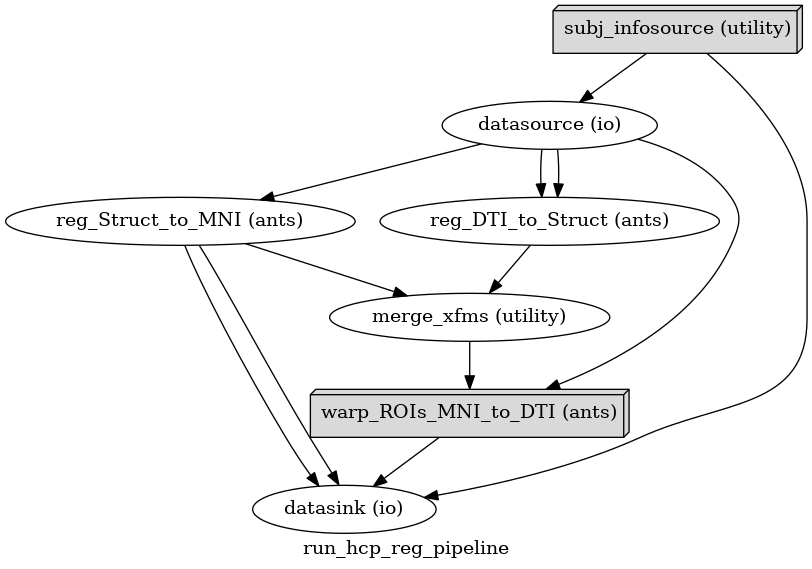

In [8]:
Image('/data/HCP_Data/NipypeScratch/run_hcp_reg_pipeline/run_hcp_reg_pipeline/graph.png')                    
#  (antsreg, datasink, [('warped_image',
#                                         'antsreg.@warped_image'),                    
                    
## I think I need to do a merge pipeline to create a list                    
                    
# forward_warp_field: (an existing file name)
#         Forward warp field
# inverse_warp_field: (an existing file name)
#         Inverse warp field
# inverse_warped_image: (an existing file name)
#         Inverse warped image
# out_matrix: (an existing file name)
#         Affine matrix
# warped_image: (an existing file name)
#         Warped image

# ref = "/data/HCP_Data/HCP_BedpostData/100206/T1w/Diffusion/nodif_brain.nii.gz"
# roi = "/data/HCP_Data/EHECHT_ROIS/Human_Hypothalamus_Left.nii.gz"

# mni_to_struct_warp = "/data/HCP_Data/NipypeScratch/run_hcp_reg_pipeline/run_hcp_reg_pipeline/_subject_id_100206/reg_Struct_to_MNI/transform1InverseWarp.nii.gz"

# dti_to_struct_matrix= "/data/HCP_Data/NipypeScratch/run_hcp_reg_pipeline/run_hcp_reg_pipeline/_subject_id_100206/reg_DTI_to_Struct/transform0GenericAffine.mat"
# ### This needs to be inverted when I apply it


# #WarpImageMultiTransform 3 $ROI_ONE ROI_ONE_to_subjDTI.nii.gz -R $DTI_B0 -i nodif_to_T1_Affine.txt -i T1_to_MNI_Affine.txt  T1_to_MNI_InverseWarp.nii.gz

# wimt = WarpImageMultiTransform()
# wimt.inputs.input_image = roi
# wimt.inputs.reference_image = ref
# wimt.inputs.transformation_series = [dti_to_struct_matrix,mni_to_struct_warp]
# wimt.inputs.invert_affine = [1]
# wimt.cmdline
#run_hcp_reg.run()

In [ ]:
ref = "/data/HCP_Data/HCP_BedpostData/100206/T1w/Diffusion/nodif_brain.nii.gz"
roi = "/data/HCP_Data/EHECHT_ROIS/Human_Hypothalamus_Left.nii.gz"

mni_to_struct_warp = "/data/HCP_Data/NipypeScratch/run_hcp_reg_pipeline/run_hcp_reg_pipeline/_subject_id_100206/reg_Struct_to_MNI/transform1InverseWarp.nii.gz"

dti_to_struct_matrix= "/data/HCP_Data/NipypeScratch/run_hcp_reg_pipeline/run_hcp_reg_pipeline/_subject_id_100206/reg_DTI_to_Struct/transform0GenericAffine.mat"
### This needs to be inverted when I apply it


#WarpImageMultiTransform 3 $ROI_ONE ROI_ONE_to_subjDTI.nii.gz -R $DTI_B0 -i nodif_to_T1_Affine.txt -i T1_to_MNI_Affine.txt  T1_to_MNI_InverseWarp.nii.gz
from nipype.interfaces.ants import WarpImageMultiTransform
wimt = WarpImageMultiTransform()
wimt.inputs.input_image = roi
wimt.inputs.reference_image = ref
wimt.inputs.transformation_series = [dti_to_struct_matrix,mni_to_struct_warp]
wimt.inputs.invert_affine = [1]
wimt.cmdline
# 'WarpImageMultiTransform 3 structural.nii structural_wimt.nii -R ants_deformed.nii.gz ants_Warp.nii.gz ants_Affine.txt'
# >>> wimt = WarpImageMultiTransform()
# >>> wimt.inputs.input_image = 'diffusion_weighted.nii'
# >>> wimt.inputs.reference_image = 'functional.nii'
# >>> wimt.inputs.transformation_series = ['func2anat_coreg_Affine.txt','func2anat_InverseWarp.nii.gz',     'dwi2anat_Warp.nii.gz','dwi2anat_coreg_Affine.txt']
# >>> wimt.inputs.invert_affine = [1]  # this will invert the 1st Affine file: 'func2anat_coreg_Affine.txt'
# >>> wimt.cmdline
# 'WarpImageMultiTransform 3 diffusion_weighted.nii diffusion_weighted_wimt.nii -R functional.nii -i func2anat_coreg_Affine.txt func2anat_InverseWarp.nii.gz dwi2anat_Warp.nii.gz dwi2anat_coreg_Affine.txt'

# #d_to_s_op= lambda x: str(os.path.join(regScratchDir,str(x),"%s_DTI_to_Struct_" % x))
# d_to_s_op= lambda x: ("/data/HCP_Data/NipypeScratch/run_hcp_reg/%s/%s_DTI_to_Struct_" % (x,x))

res = wimt.run()
#WarpImageMultiTransform 3 $ROI_ONE ROI_ONE_to_subjDTI.nii.gz -R $DTI_B0 -i nodif_to_T1_Affine.txt -i T1_to_MNI_Affine.txt  T1_to_MNI_InverseWarp.nii.gz
res.outputs

In [ ]:
#reg_DTI_to_Struct = mem.cache(RegistrationSynQuick)

# for subjID in completeSubjs:
#     subjWD = os.path.join(regScratchDir,str(subjID))
#     if not os.path.isdir(subjWD):
#         os.makedirs(subjWD)

#     ### DTI -->  STRUCT
#     struct_brain = '/data/HCP_Data/HCP_BedpostData/%s/T1w/T1w_acpc_dc_masked.nii.gz' % subjID
#     nodif_brain = '/data/HCP_Data/HCP_BedpostData/%s/T1w/Diffusion/nodif_brain.nii.gz' % subjID
#     MNI_1MM = '/usr/share/fsl/5.0/data/standard/MNI152_T1_1mm_brain.nii.gz'

#     d_to_s_op= os.path.join(regScratchDir,str(subjID),"%s_DTI_to_Struct_" % subjID)
#     s_to_MNI_1mm_op = os.path.join(regScratchDir,str(subjID),"%s_Struct_to_MNI_1mm_" % subjID)
    
#     reg_DTI_to_Struct(moving_image=nodif_brain,fixed_image=struct_brain,num_threads=24,
#                       transform_type='r',output_prefix=d_to_s_op)
    
#     #### Struct --> MNI
#     reg_Struct_to_MNI(moving_image=struct_brain,fixed_image=MNI_1MM,num_threads=24,
#                      output_prefix=s_to_MNI_1mm_op)
    
#     ## TO DO-- COMBINE ROIS

In [ ]:
reg_DTI_to_Struct.cmdline
#/usr/lib/ants/ANTS 3 -m PR[MNI152_T1_1mm_brain.nii.gz,T1w_acpc_dc_masked.nii.gz,1,4] 
# -t SyN[0.25] -r Gauss[3,0] -o T1_to_MNI_ -i 30x90x20 --use-Histogram-Matching 
# --number-of-affine-iterations 10000x10000x10000x10000x10000 --MI-option 32x16000


In [ ]:
# wi = result.outputs.warped_image
# from niwidgets import NiftiWidget
# from niwidgets import examplet1

# test_widget = NiftiWidget(wi)
# test_widget.nifti_plotter()


# fixed_widget = NiftiWidget( "/data/HCP_Data/HCP_BedpostData/100206/T1w/T1w_acpc_dc_masked.nii.gz")
# fixed_widget.nifti_plotter()

In [ ]:
### Concepts/Steps

## 3 Spaces     DTI    ---- >    T1        --->MNI
## DTI is probably "best" registered using the nodif_brain which is the first image of the "data.nii.gz" file
#antsIntroduction.sh -d 3 -r $MNI_BRAIN  -i $T1_BRAIN -o T1_to_MNI_ -t GR


In [ ]:
# DTI='/data/HCP_Data/HCP_BedpostData/100610/T1w/Diffusion/data.nii.gz'
# DTI_B0='/data/HCP_Data/HCP_BedpostData/100610/T1w/Diffusion/nodif_brain.nii.gz'
# DTI_M='/data/HCP_Data/HCP_BedpostData/100610/T1w/Diffusion/nodif_brain_mask.nii.gz'
# T1_M='/data/HCP_Data/HCP_BedpostData/100610/T1w/brainmask_fs.nii.gz'
# T1='/data/HCP_Data/HCP_BedpostData/100610/T1w/T1w_acpc_dc.nii.gz'
# # DTI_TO_T1='/data/HCP_Data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/sampleAntsRegData/nodif_to_T1_deformed.nii.gz
# MNI_BRAIN='/usr/share/fsl/5.0/data/standard/MNI152_T1_1mm_brain.nii.gz'
# #T1_BRAIN=''/HCP_Data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/sampleAntsRegData/T1w_acpc_dc_masked.nii.gz
# ROI_ONE='/data/HCP_Data/EHECHT_ROIS/Human_Hypothalamus_Left.nii.gz' 


In [ ]:

# echo $IN $T1_M $T1

# ## NOTES PROBABLY wouLD bE QUICKER IF WE USED THE T1 IMAGE WIHT THE MASK APPLIED... TO DO!!

# export PATH=$PATH:/usr/lib/ants
# export ANTSPATH=/usr/lib/ants

# ## Get the first B0 image from the DTI data set
# #fslroi $DTI $DTI_B0 0 1 


# ## Register the B0/DTI image to the T1 --- we perhaps should have used the masked/brainonly T1??
# #antsIntroduction.sh -d 3 -r $T1 -i $DTI_B0 -o nodif_to_T1_ -t RI


# ## Need to apply the brain mask to the T1 image to speed things up
# #fslmaths $T1 -mas $T1_M $T1_MASKED


# ### Thsi registers the T1 Brain image nonlinearly to MNI Space.. and also generated the inverse warp
# #antsIntroduction.sh -d 3 -r $MNI_BRAIN  -i $T1_BRAIN -o T1_to_MNI_ -t GR

# ### note T1_To_MNI_Warp is the warp transform.. and we add two affine matrices which are also real files
# #WarpImageMultiTransform 3 $DTI_B0  nodif_to_MNI_test.nii.gz -R $MNI_BRAIN  T1_to_MNI_Warp.nii.gz T1_to_MNI_Affine.txt nodif_to_T1_Affine.txt


# ### THIS GOES IN REVERSE
# WarpImageMultiTransform 3 $ROI_ONE ROI_ONE_to_subjDTI.nii.gz -R $DTI_B0 -i nodif_to_T1_Affine.txt -i T1_to_MNI_Affine.txt  T1_to_MNI_InverseWarp.nii.gz
# WarpImageMultiTransform 3 $ROI_ONE ROI_ONE_to_subjDTI_NN.nii.gz -R $DTI_B0 --use-NN -i nodif_to_T1_Affine.txt -i T1_to_MNI_Affine.txt  T1_to_MNI_InverseWarp.nii.gz

# ## --use-NN: Use Nearest Neighbor Interpolation. 
 
# #runpbx.connect(subj_infosource,'subject_id',datasource,'subject_id')
# runpbx2  = pe.Workflow(name="runpbx2_gpu")
# runpbx2.base_dir = "/data/NipypeScratch/"

# samples_base_name_fxn = lambda x : x.replace('_th1samples.nii.gz','')


# runpbx2.connect(subj_infosource,'subject_id',datasource,'subject_id')
# # ### Connect the dti_datasource to the pbx2 command
# runpbx2.connect( datasource,'thsamples',pbx2,'thsamples')
# runpbx2.connect( datasource,'phsamples',pbx2,'phsamples')
# runpbx2.connect( datasource,'fsamples',pbx2,'fsamples')
# runpbx2.connect( datasource,'nodif_brain_mask',pbx2,'mask')
# runpbx2.connect( datasource, ('thsamples', samples_base_name_fxn ), pbx2,'samples_base_name') ###  NOTE THIS IS A WEIRD TUPLE IS

# # runpbx2.run()
# runpbx2.run(plugin='MultiProc', plugin_args={'n_procs' : 1})

#run_hcp_reg.connect( subj_infosource,('subject_id',d_to_s_op),reg_DTI_to_Struct,'output_prefix')

# runpbx2.connect( datasource,'fsamples',pbx2,'fsamples')
# runpbx2.connect( datasource,'nodif_brain_mask',pbx2,'mask')
# runpbx2.connect( datasource, ('thsamples', samples_base_name_fxn ), pbx2,'samples_base_name') ###  NOTE THIS IS A WEIRD TUPLE IS
    

END PRODUCT:   We will create a directory in Diffusion or maybe ROIs and maybe a subdirectory called DTI
    
    so /{SubjID}/T1w/ROIs/DTI_Space/Human_L_Hypothalamus.nii
       /{SubjID}/xfms/<<PUT XFMS HERE>> 
        

### Start with the MNI-space hypothalamus / basal forebrain ROIs à want to end up with tractography in all subjects in MNI space

 

Compute rigid body transform from diffusion space to T1

antsIntroduction.sh -d 3 -r T1.nii.gz -i nodif.nii.gz -o nodif_to_T1_ -t RI

 

Compute nonlinear warp from T1 to MNI

antsIntroduction.sh -d 3 -r MNI.nii.gz -i T1.nii.gz -o T1_to_MNI_ -t GR

(I think GR (greedy Syn) should be faster than SY (Syn) which is the default and apparently I’ve been using GR with good results so far)

 

Apply transformations so you can check that it all looks OK

WarpImageMultiTransform 3 nodif.nii.gz nodif_to_MNI.nii.gz -R MNI.nii.gz T1_to_MNI_Warp.nii.gz T1_to_MNI_Affine.txt DTI_to_T1_Affine.txt

Then check that nodif-to-MNI mappings look good: slicesdir –p MNI_template.nii.gz Subj_*_nodif_to_MNI.nii.gz

 

Apply INVERSE transformation from MNI-space ROIs to individual subjects’ diffusion space

WarpImageMultiTransform 3 template_ROI.nii.gz SubjX_ROI.nii.gz –R nodif.nii.gz –i DTI_to_T1_Affine.txt –i T1_to_MNI_Affine.txt T1_to_MNI_InverseWarp.nii.gz

 

Run probtrackx using native-space ROIs… this will produce a native-space fdt_paths.nii.gz file.  Threshold and normalize in native space.

 

Apply transformations to get thresholded, normalized tracts into MNI space

WarpImageMultiTransform 3 fdt_paths_thresh_norm.nii.gz SubjX_fdt_paths_thresh_norm_in_MNIspace.nii.gz -R MNI.nii.gz T1_to_MNI_Warp.nii.gz T1_to_MNI_Affine.txt DTI_to_T1_Affine.txt

 

Fslmerge –t Subj*_fdt_paths_thresh_norm_in_MNIspace.nii.gz à this becomes the input for randomise

 

In [ ]:
DTI=/HCP_Data/HCP_BedpostData/100610/T1w/Diffusion/data.nii.gz
DTI_B0=/HCP_Data/HCP_BedpostData/100610/T1w/Diffusion/nodif_brain.nii.gz
DTI_M=/HCP_Data/HCP_BedpostData/100610/T1w/Diffusion/nodif_brain_mask.nii.gz
T1_M=/HCP_Data/HCP_BedpostData/100610/T1w/brainmask_fs.nii.gz
T1=/HCP_Data/HCP_BedpostData/100610/T1w/T1w_acpc_dc.nii.gz
DTI_TO_T1=/HCP_Data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/sampleAntsRegData/nodif_to_T1_deformed.nii.gz
MNI_BRAIN=/usr/share/fsl/5.0/data/standard/MNI152_T1_1mm_brain.nii.gz 

T1_BRAIN=/HCP_Data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/sampleAntsRegData/T1w_acpc_dc_masked.nii.gz

ROI_ONE=/HCP_Data/EHECHT_ROIS/Human_Hypothalamus_Left.nii.gz  


echo $IN $T1_M $T1

## NOTES PROBABLY wouLD bE QUICKER IF WE USED THE T1 IMAGE WIHT THE MASK APPLIED... TO DO!!

export PATH=$PATH:/usr/lib/ants
export ANTSPATH=/usr/lib/ants

## Get the first B0 image from the DTI data set
#fslroi $DTI $DTI_B0 0 1 


## Register the B0/DTI image to the T1 --- we perhaps should have used the masked/brainonly T1??
#antsIntroduction.sh -d 3 -r $T1 i $DTI_B0 -o nodif_to_T1_ -t RI


## Need to apply the brain mask to the T1 image to speed things up
#fslmaths $T1 -mas $T1_M $T1_MASKED


### Thsi registers the T1 Brain image nonlinearly to MNI Space.. and also generated the inverse warp
#antsIntroduction.sh -d 3 -r $MNI_BRAIN  -i $T1_BRAIN -o T1_to_MNI_ -t GR

### note T1_To_MNI_Warp is the warp transform.. and we add two affine matrices which are also real files
#WarpImageMultiTransform 3 $DTI_B0  nodif_to_MNI_test.nii.gz -R $MNI_BRAIN  T1_to_MNI_Warp.nii.gz T1_to_MNI_Affine.txt nodif_to_T1_Affine.txt

### THIS GOES IN REVERSE
WarpImageMultiTransform 3 $ROI_ONE ROI_ONE_to_subjDTI.nii.gz -R $DTI_B0 -i nodif_to_T1_Affine.txt -i T1_to_MNI_Affine.txt  T1_to_MNI_InverseWarp.nii.gz
WarpImageMultiTransform 3 $ROI_ONE ROI_ONE_to_subjDTI_NN.nii.gz -R $DTI_B0 --use-NN -i nodif_to_T1_Affine.txt -i T1_to_MNI_Affine.txt  T1_to_MNI_InverseWarp.nii.gz

## --use-NN: Use Nearest Neighbor Interpolation. 
 
#
#Then check that nodif-to-MNI mappings look good: slicesdir –p MNI_template.nii.gz Subj_*_nodif_to_MNI.nii.gz
#Apply INVERSE transformation from MNI-space ROIs to individual subjects’ diffusion space
#WarpImageMultiTransform 3 template_ROI.nii.gz SubjX_ROI.nii.gz –R nodif.nii.gz –i DTI_to_T1_Affine.txt –i T1_to_MNI_Affine.txt T1_to_MNI_InverseWarp.nii.gz
 

#Run probtrackx using native-space ROIs… this will produce a native-space fdt_paths.nii.gz file.  Threshold and normalize in native space.


#Apply transformations to get thresholded, normalized tracts into MNI space

#WarpImageMultiTransform 3 fdt_paths_thresh_norm.nii.gz SubjX_fdt_paths_thresh_norm_in_MNIspace.nii.gz -R MNI.nii.gz T1_to_MNI_Warp.nii.gz T1_to_MNI_Affine.txt DTI_to_T1_Affine.txt

 

#Fslmerge –t Subj*_fdt_paths_thresh_norm_in_MNIspace.nii.gz à this becomes the input for randomi

